In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.pdfigcapx.utils import extract_page_text_content, sort_by_most_common_value_desc
from selenium import webdriver
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

from src.pdfigcapx.html_content import HtmlPage, PageBoxesCounts
from src.pdfigcapx.layout import PdfLayout

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
driver = webdriver.Chrome('chromedriver', options=chrome_options)

## Sample Data
We have preprocessed a PDF document (**/tests/data/pdf-1.pdf**) and obtained 
and HTML and PNG representation for each PDF page. The PNG representation shows
the page background that can include images but no text. The HTML page contains
all text information inside DIVs.

In [3]:
number_pages = 13
file_path = '../tests/data/html-2/page'

htmls = []
pngs  = []
for i in range(1, number_pages+1):
  htmls.append(str(Path(f"{file_path}{i}.html").resolve()))
  pngs.append(str(Path(f"{file_path}{i}.png").resolve()))

pages = []
for html in htmls:
  pages.append(extract_page_text_content(driver, html))

## Find Local Counts?

In [4]:
MIN_TEXT_LENGTH = 30
layout = PdfLayout([pages[0]], min_text_length=MIN_TEXT_LENGTH)

In [5]:
def draw_page_elements(ax, page: HtmlPage, png_path: str, min_text_length=30):
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)
  # _, ax = plt.subplots(dpi=150)

  layout = PdfLayout([page], min_text_length=min_text_length)
  (left_bbox, right_bbox, top_bbox, bottom_bbox) = layout.find_surrounding_bboxes()

  # contrains in Y axis for finding text
  text_area = patches.Rectangle((0, layout.text_y_min),
                              layout.page_width,
                              layout.text_y_max-layout.text_y_min,
                              linewidth=0,
                              edgecolor='none',
                              facecolor='y',
                              alpha=0.2)
  ax.add_patch(text_area)

  # DIVs with text on page, red ones are smaller than minimum length
  for text_box in page.text_boxes:
    color = 'b' if len(text_box.text) > min_text_length else 'r'
    rect = patches.Rectangle((text_box.x_top_left, text_box.y_top_left),
                              text_box.width, text_box.height,
                              linewidth=0,
                              edgecolor='none',
                              facecolor=color,
                              alpha=0.4)
    ax.add_patch(rect)

  # minimum x for the most common x0 in text boxes
  ax.plot([layout.text_x_common_min, layout.text_x_common_min],
          [0, page.height],
          color="g", linestyle='--')

  # minimum x0
  ax.plot([layout.text_x_min, layout.text_x_min],
          [0, page.height],
          color="g", linestyle='--')

  for bbox in (left_bbox, right_bbox, top_bbox, bottom_bbox):
    rect = patches.Rectangle((bbox.x0, bbox.y0),
                              bbox.width, bbox.height,
                              linewidth=0,
                              edgecolor='none',
                              facecolor='gray',
                              alpha=0.5)
    ax.add_patch(rect)          

  ax.imshow(page_image)

In [6]:
def plot3(start, pages, pngs):
   cols = 3
   _, ax = plt.subplots(1,cols,dpi=200)
   for idx, page in enumerate(pages[start:start+cols]):   
      draw_page_elements(ax[idx], page, pngs[start+idx], min_text_length=MIN_TEXT_LENGTH)

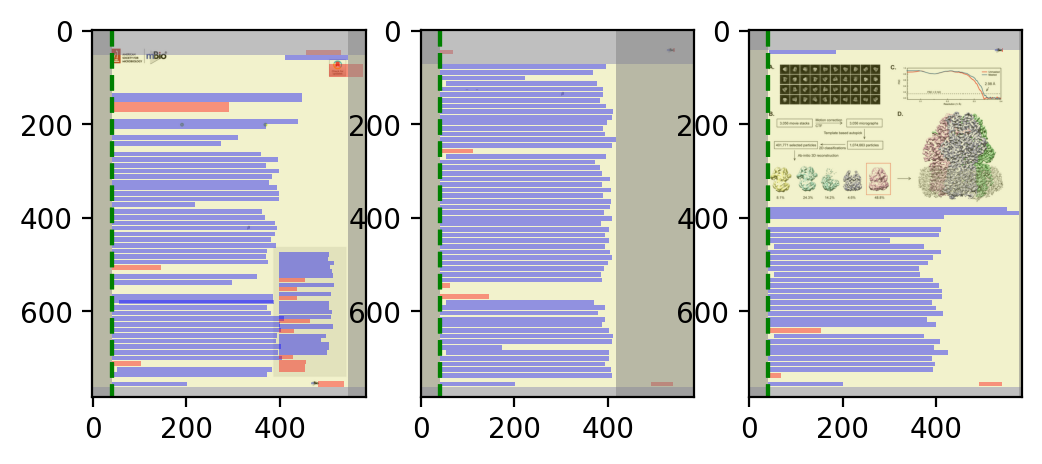

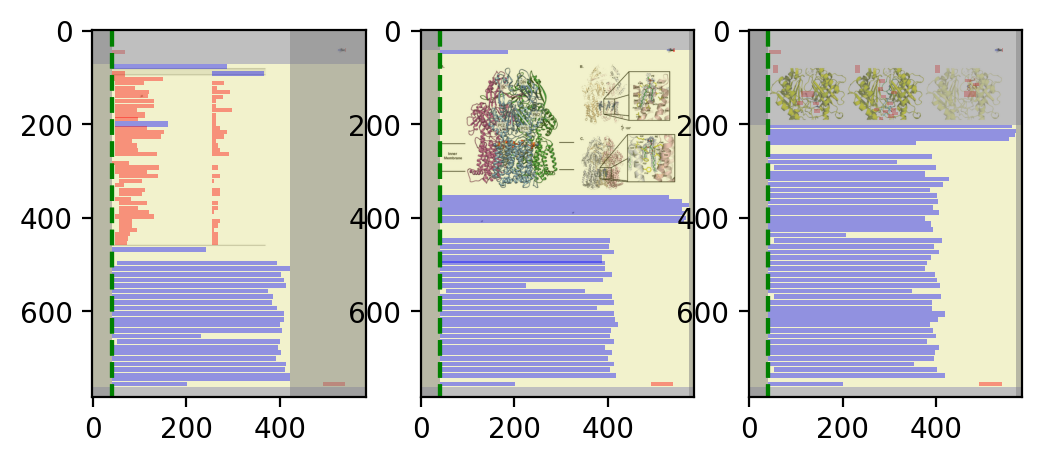

In [7]:
plot3(0, pages, pngs)
plot3(3, pages, pngs)

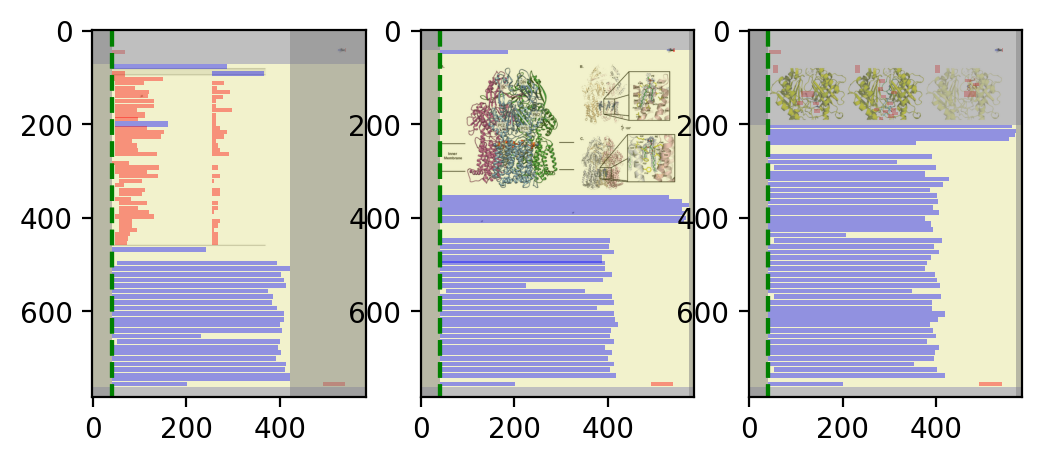

In [8]:
plot3(3, pages, pngs)

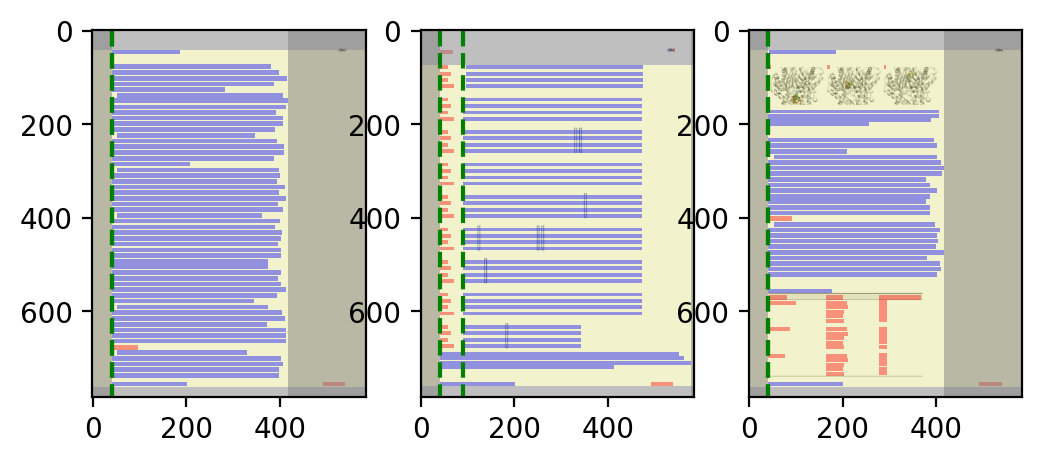

In [9]:
plot3(6, pages, pngs)

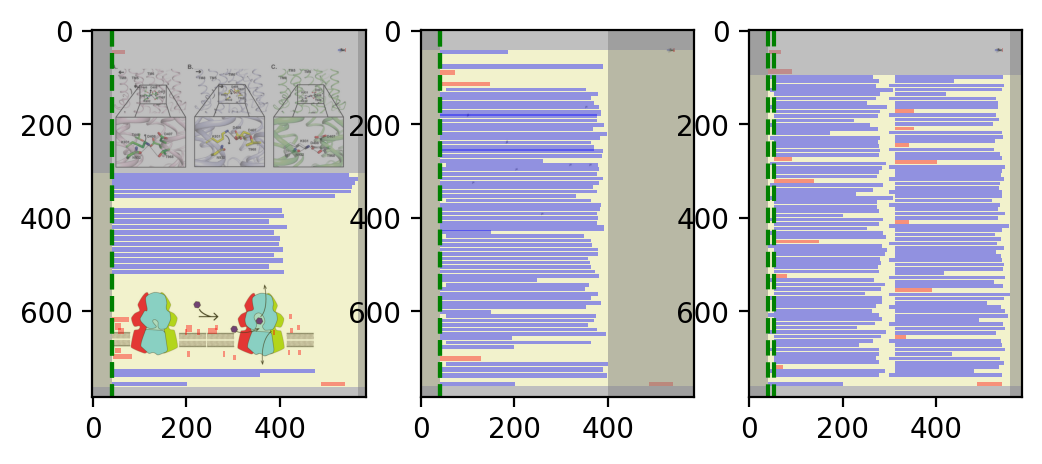

In [10]:
plot3(9, pages, pngs)

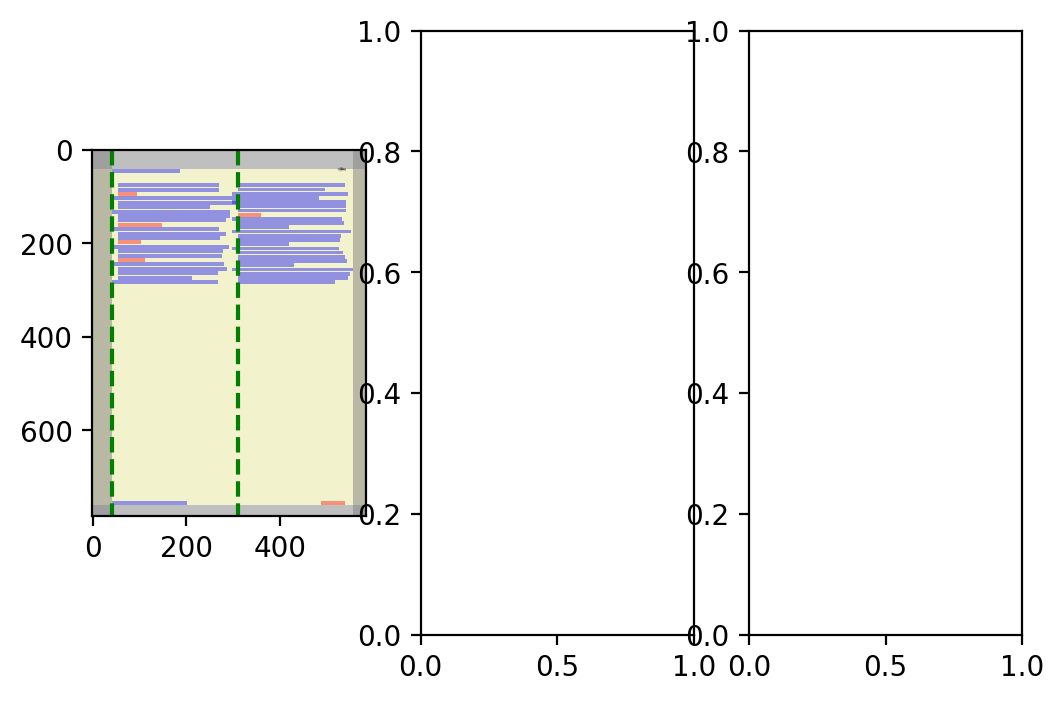

In [11]:
plot3(12, pages, pngs)

In [12]:
# figures caption list (input_path, pdf, xpdf_path)
# input_path, where all PDFs are
# current pdf name
# xpdf_path where to locate the xpdf

# box_dectection
# html_file_path -> where the html files are
# info: layout calc above
# html_boxes -> text_boxes



In [13]:
import cv2

In [14]:
page_number = 2
layout = PdfLayout([pages[page_number]], min_text_length=MIN_TEXT_LENGTH)

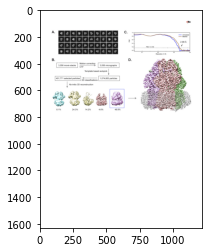

In [15]:
img = cv2.imread(pngs[page_number])
plt.imshow(img)

In [16]:
# height, width, channels
img_height, img_width, _ = img.shape
scale_ratio = float(img_height) / layout.page_height if img_height > img_width else float(img_width) / layout.page_width

In [17]:
# text_elements are the text_boxes for the page, if process per page, don't need for lines 119-121

page = pages[2]
for text_box in pages[2].text_boxes:
  text = text_box.text

  # i don't understand the row_height
  page_word = [max(text_box.x_top_left - layout.row_height, 0), text_box.y_top_left, text_box.width + 2 * layout.row_height, text_box.height]
  print(page_word)
  break


[32, 41, 165, 8]


In [18]:
def draw_page_elements2(page: HtmlPage, png_path: str, min_text_length=30):
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)
  _, ax = plt.subplots(dpi=200)

  # DIVs with text on page, red ones are smaller than minimum length
  for text_box in page.text_boxes:
    color = 'b' if len(text_box.text) > min_text_length else 'r'

    if text_box.text.lower().startswith('fig'):
      print(text_box.text)
      color = 'g'

    rect = patches.Rectangle((text_box.x_top_left, text_box.y_top_left),
                              text_box.width, text_box.height,
                              linewidth=1,
                              edgecolor=color,
                              facecolor=color,
                              alpha=0.4)
    ax.add_patch(rect)         
  
  tb = page.text_boxes[0]
  circle = patches.Circle((tb.x_top_left, tb.y_top_left), radius=1, color='black')
  ax.add_patch(circle)

  circle = patches.Circle((tb.x_top_left-layout.row_height, tb.y_top_left), radius=1, color='red')
  ax.add_patch(circle)

  circle = patches.Circle((tb.width+ 2 * layout.row_height, tb.y_top_left+tb.height), radius=1, color='red')
  ax.add_patch(circle)

  circle = patches.Circle((tb.x_top_right, tb.y_top_left+tb.height), radius=1, color='black')
  ax.add_patch(circle)  

  ax.imshow(page_image)

FIG 1 Cryo-EM analysis of the A. baumannii AdeB multidrug efﬂux pump. (A) Representative 2D classes. (B) Data processing ﬂowchart with particle distributions.


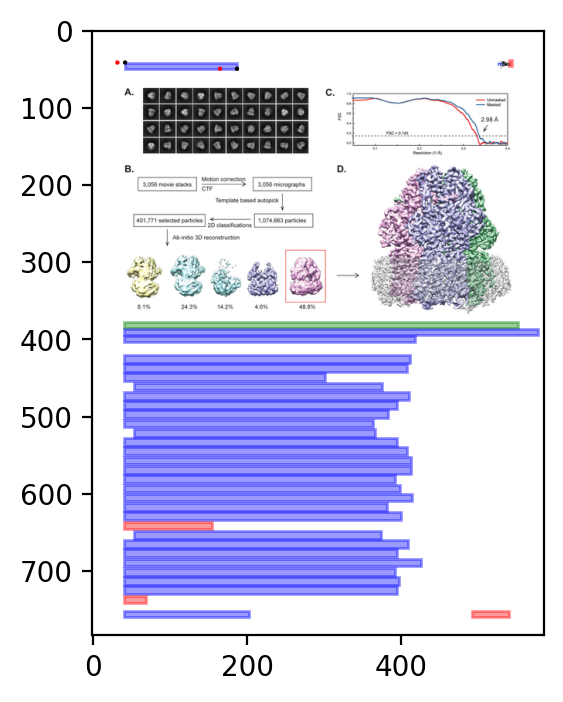

In [19]:
draw_page_elements2(pages[page_number], pngs[page_number])

In [20]:
def overlap_ratio_based(box1, box2):
    # overlap ratio based on box1
    box1_x0 = box1[0]
    box1_y0 = box1[1]
    box1_x1 = box1[0] + box1[2]
    box1_y1 = box1[1] + box1[3]

    box2_x0 = box2[0]
    box2_y0 = box2[1]
    box2_x1 = box2[0] + box2[2]
    box2_y1 = box2[1] + box2[3]

    SI = max(0, min(box1_x1, box2_x1) - max(box1_x0, box2_x0)) * \
        max(0, min(box1_y1, box2_y1) - max(box1_y0, box2_y0))
    box1_area = box1[2] * box1[3]
    
    if box1_area == 0:
        overlap_ratio = 0
    else:
        overlap_ratio = float(SI) / box1_area
    return overlap_ratio

In [25]:
import numpy as np

page_number = 2
page = pages[page_number]
layout = PdfLayout([page], min_text_length=MIN_TEXT_LENGTH)

caption_boxes = []
for text_box in pages[2].text_boxes:
  if text_box.text.lower().startswith('fig'):
    caption_boxes.append(text_box)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 240, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations=1)
_, contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
new_thresh = np.zeros(thresh.shape, dtype=np.uint8)

for contour in contours:
  bbox = cv2.boundingRect(contour)
  scaled_bbox = [int(float(i) / scale_ratio) for i in bbox]  
  
  box_image = 0
  for caption_box in caption_boxes:
    cbox = [caption_box.x_top_left, caption_box.y_top_left, caption_box.width, caption_box.height]
    box_image = box_image + overlap_ratio_based(cbox, scaled_bbox)
  if box_image < 0.5:
    cv2.drawContours(new_thresh, [contour], 0, 255, -1)

new_thresh2 = new_thresh.copy()
potential_bbox = []

# check overlap with border bounding boxes
for contour in contours:
  bbox = cv2.boundingRect(contour)
  thresh_for_figure = layout.row_height * scale_ratio * 1.5

  if bbox[3] > thresh_for_figure and bbox[2] > thresh_for_figure:
    p_bbox = [int(float(x) / scale_ratio) for x in bbox]
    # Format checking, to filter box that at top, down, left or right
    (left_bbox, right_bbox, top_bbox, down_bbox) = layout.find_surrounding_bboxes()
    ol_left = overlap_ratio_based(p_bbox, [left_bbox.x0, left_bbox.y0, left_bbox.width, left_bbox.height])
    ol_right = overlap_ratio_based(p_bbox, [right_bbox.x0, right_bbox.y0, right_bbox.width, right_bbox.height])    
    ol_top = overlap_ratio_based(p_bbox, [top_bbox.x0, top_bbox.y0, top_bbox.width, top_bbox.height])
    ol_down = overlap_ratio_based(p_bbox, [down_bbox.x0, down_bbox.y0, down_bbox.width, down_bbox.height])
    ol_sum = 0
    ol_sum = ol_down + ol_left + ol_right + ol_top
    if ol_sum < 0.1:
      potential_bbox.append(p_bbox)

# check overlap with text boxes
text_boxes = page.text_boxes.copy()
for i in range(len(potential_bbox)-1, 0, -1):
  for text_box in text_boxes:
    txtbbox = text_box.to_bbox()
    overlap = overlap_ratio_based(potential_bbox[i], txtbbox)
    if overlap > 0.1:
      text_boxes.pop()

# then estimate number of figures


    






In [27]:
import re
re.search(r'\d', caption_boxes[0].text) 

<re.Match object; span=(4, 5), match='1'>

In [32]:
temp_max = 0
# search for a digit
temp_max = max(int(re.search(r'\d+', caption_boxes[0].text).group()), temp_max)
temp_max

1

In [34]:
re.search(r'\d+', caption_boxes[0].text).group()

'1'

In [33]:
caption_boxes[0].text

'FIG 1 Cryo-EM analysis of the A. baumannii AdeB multidrug efﬂux pump. (A) Representative 2D classes. (B) Data processing ﬂowchart with particle distributions.'

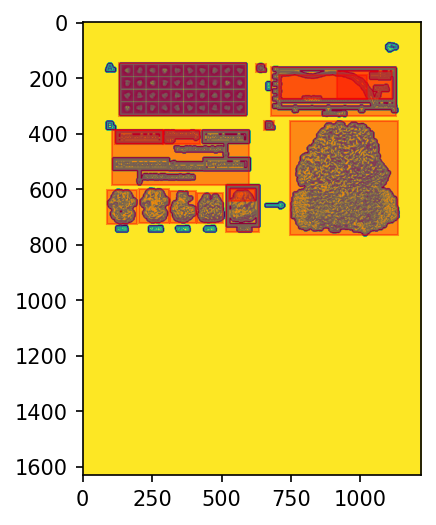

In [ ]:
fig, ax = plt.subplots(dpi=150)

# page_image = cv2.resize(img_gray, (page.width, page.height))

for bbox in potential_bbox:
  rect = patches.Rectangle((bbox[0] * scale_ratio, bbox[1] * scale_ratio),
                              bbox[2] * scale_ratio, bbox[3] * scale_ratio,
                              linewidth=1,
                              edgecolor='r',
                              facecolor='r',
                              alpha=0.4)
  ax.add_patch(rect)

ax.imshow(cv2.drawContours(img_gray, contours, -1, (0,255,0), 3))

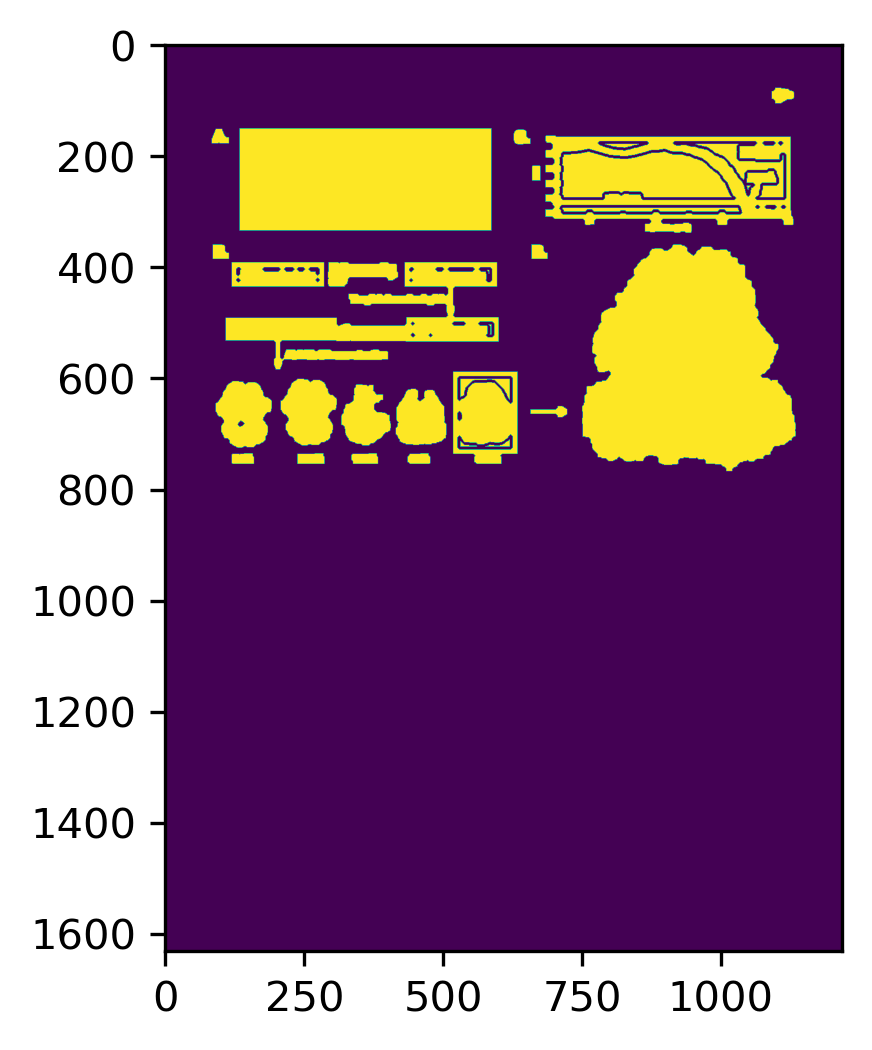

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.imshow(cv2.drawContours(new_thresh, contours, -1, (0,255,0), 3))

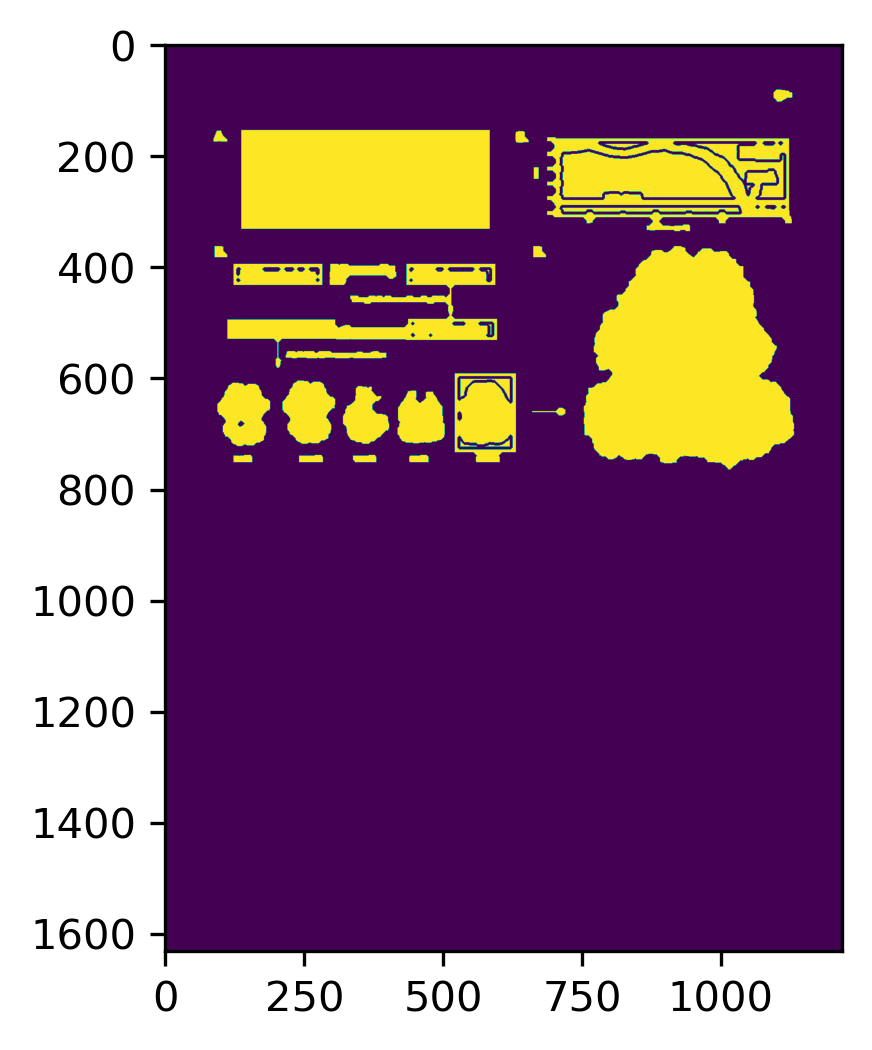

In [ ]:
copy_image = new_thresh.copy()
_, contours, _ = cv2.findContours(copy_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ig, ax = plt.subplots(dpi=300)
ax.imshow(cv2.drawContours(copy_image, contours, -1, (0,255,0), 3))

In [ ]:
# line 176 xpdf_process